# Scoring business profit (or loss) from wx verification data 

In [2]:
# packages needed: xarray, pandas, numpy for random 

import xarray as xr 
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt

In [39]:
# Utility for a coastline() function for quick plots 
DEM05 = xr.open_dataset('./DEM.halfdeg.nc')
# For positive-only longitudes do these steps, for -180-180 no 
DEM05 = DEM05.roll(lon=(DEM05.sizes['lon'] // 2))
DEM05['lon'] = (DEM05['lon'] + 180) % 360

def coastline(**kwargs): 
    DEM05.z.plot.contour(vmin=0, vmax=0.01, **kwargs)

## Get verification data: T & soil water at a given time

In [42]:
# For demo, air (T2m) and soilw in NCEP reanalysis https://psl.noaa.gov/thredds/catalog/Datasets
# For a course, see Instructor_Prepare_Dataset 

VERIF = '2020-04-01-00'

Tverif = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Aggregations/ncep.reanalysis/surface/air.sig995.nc'). \
                         sel(time=VERIF)
soilw = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Aggregations/ncep.reanalysis/surface_gauss/soilw.0-10cm.gauss.nc'). \
                         sel(time=VERIF)

# Heights for a weather map 
Z = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Aggregations/ncep.reanalysis/pressure/hgt.nc'). \
                        sel(time=VERIF)

## Sample the grid at a geographical portfolio of interest points 

In [45]:
sites = pd.read_csv('../BiznessSpecificParameters/Geographical_Sampling_Points.csv')
sitelons = xr.DataArray(sites.Longitude)+360.
sitelats = xr.DataArray(sites.Latitude)

sites

,Unnamed: 0,City,Latitude,Longitude
0,0,New York,40.7128,-74.0060
1,1,Los Angeles,34.0522,-118.2437
2,2,Chicago,41.8781,-87.6298
3,3,Houston,29.7604,-95.3698
4,4,Phoenix,33.4484,-112.0740


## Quick map plot of T2m, Z500, sites

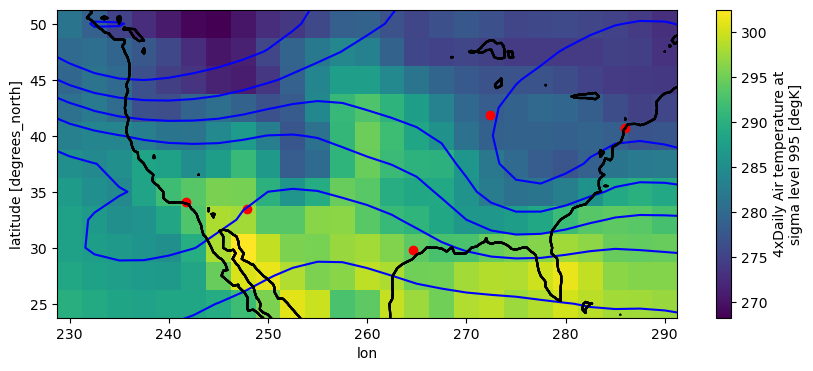

In [49]:
Tverif.air.sel(lat = slice(50,25), lon=slice(360-130,360-70))\
    .plot(size=4, aspect=2.5)
Z.hgt.sel(level=500).plot.contour(colors='b', levels=20)
plt.scatter(sitelons, sitelats, c='red')
coastline(colors='k')

## Downscale model grids to site-scale point verification 

Placeholder: just add random noise, magnitude specified 0.5K. 

Better: difference between interpolated and nearest-gridpoint values?

In [51]:
# Extract values at nearest gridpoint, add noise

T_grids = Tverif.sel(lon = sitelons, lat = sitelats, method='nearest')
sw_grids = soilw.sel(lon = sitelons, lat = sitelats, method='nearest')

Tnoise = np.random.random( sitelons.size )-0.5   # random on [0,1] - 0.5

## Profit: a nonlinear function on domain of wx verification
### adjusted for preparations, made in advance on the basis of forecasts 

Demo: All extremes are costly, optimim a bit warmer than climatology, penalty for freezing. Of course this varies by business application. 

In [57]:
def value_of_preparations(preps):
    return 0    # constant, or array the same shape as costfunction

In [65]:
# profit function, from BiznessSpecificParameters

siteTs = T_grids.air    + Tnoise
siteWs = sw_grids.soilw             # silly for coastal sites, FIX ME

profitfunction = xr.open_dataset('../BiznessSpecificParameters/profitfunction.nc')  
#preps = pd.read_csv('TEAMDATA/current_preps.csv')

siteprofits = profitfunction.sel(T = siteTs, soilw = siteWs, method='nearest') \
#            + value_of_preparations(preps)

# display results (dataframe = table)
siteprofits.to_dataframe()

,profit,soilw,T,time
dim_0,,,,
0,-557.598714,1.000000,278.484848,2020-04-01
1,-439.733190,1.000000,293.838384,2020-04-01
2,6.119274,0.343434,278.484848,2020-04-01
3,19.403632,0.242424,293.838384,2020-04-01
4,-34.998980,0.232323,297.474747,2020-04-01


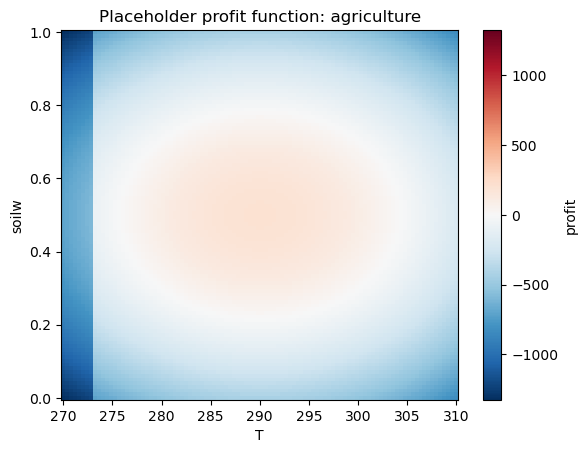

In [68]:
profitfunction.profit.plot();
plt.title('Placeholder profit function: agriculture');